## Intro

- Notebook for loading MNIST dataset and computing thickness scores

## Parameters

In [1]:
threash = 0.5                     # Threashold for discretizing digits when computing thick scores
n_cats = 10                       # Number of catagories for discrete thick scores
save_loc = "saved/basic_mnist"    # Where to save data

## Imports

In [2]:
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import math

# import tensorflow as tf

import skimage.transform as skt
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize

from my_lib.save_load import save_datasets

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

## Esitmating thickness (Example)

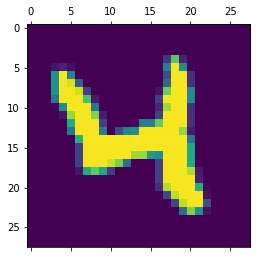

In [4]:
img0 = x_train[20]
plt.matshow(img0)

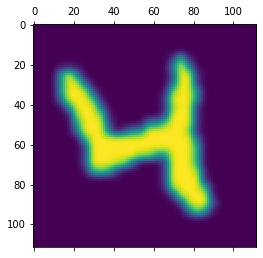

In [5]:
img1 = skt.pyramid_expand(img0, 4)
plt.matshow(img1)

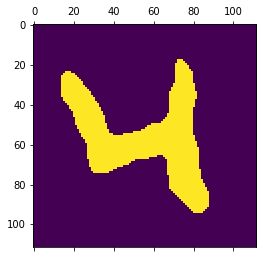

In [6]:

img2 = img1 > threash 
plt.matshow(img2)

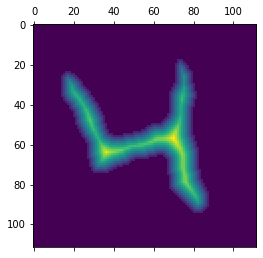

In [7]:
img3 = distance_transform_edt(img2)
plt.matshow(img3)

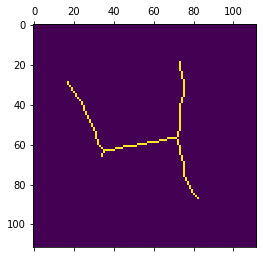

In [8]:
img4 = skeletonize(img2)
plt.matshow(img4)

In [9]:
mean_thickness = np.mean(img3[img4])
mean_thickness

6.900640190506612

## Compute all thickness scores

In [10]:
def compute_raw_score(img0, threash=0.5, upsc=4):
    img1 = skt.pyramid_expand(img0, upsc)
    img2 = img1 > threash 
    img3 = distance_transform_edt(img2)
    img4 = skeletonize(img2)
    return np.mean(img3[img4])

In [11]:


raw_thick_scores_by_dig = [[] for _ in range(10)]
raw_thick_scores = []
raw_thick_scores_test = []


for x, lbl in zip(x_train, y_train):

    rts = compute_raw_score(x, threash=threash)
    raw_thick_scores.append(rts)
    raw_thick_scores_by_dig[lbl].append(rts)
        
        
for x, lbl in zip(x_test, y_test):

    rts = compute_raw_score(x, threash=threash)
    raw_thick_scores_test.append(rts)

In [12]:

# Hacky code, sets up conv_raw score function
clip = (5, 30) # remove this many outliers from each end for each digit
rths = [sorted(tsl)[clip[0]:-clip[1]] for tsl in raw_thick_scores_by_dig]
mm = [(np.max(rths[i]), np.min(rths[i])) for i in range(10)]
dig_t_rngs = [(x[1], x[0]-x[1]) for x in mm]



# maps raw score 'sc' to discritized integer score in [0, cats), based on label
def conv_raw_score(sc, lbl, cats=10):
    minv, rng = dig_t_rngs[lbl]
    step = rng/cats
    
    raw = int(((sc - minv)/step)//1)
    return max(min(raw, cats-1), 0)

In [13]:
thicks_disc = []
thicks_disc_test = []


for x, lbl, raw_sc in zip(x_train, y_train, raw_thick_scores):
    
    thicks_disc.append(conv_raw_score(raw_sc, lbl, cats=n_cats))


for x, lbl, raw_sc in zip(x_test, y_test, raw_thick_scores_test):

    thicks_disc_test.append(conv_raw_score(raw_sc, lbl, cats=n_cats))


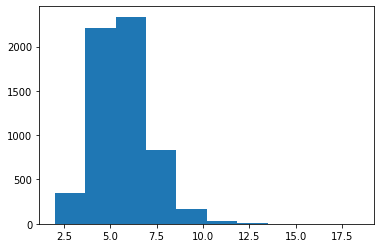

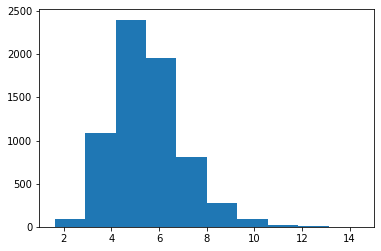

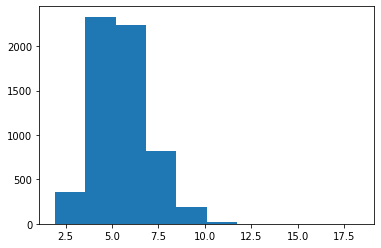

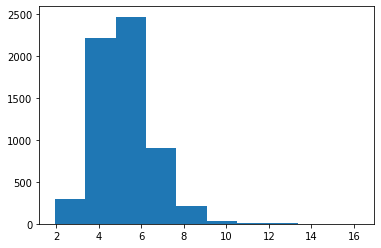

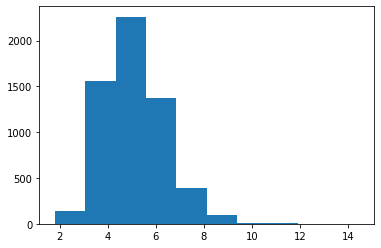

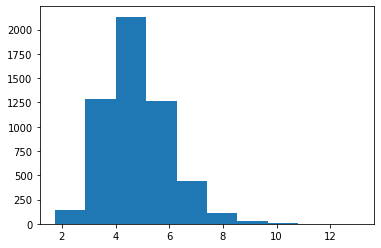

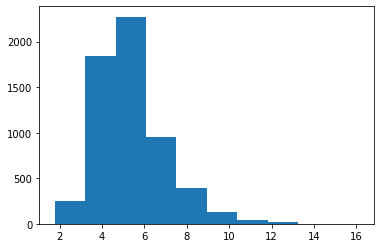

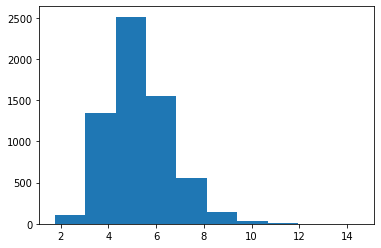

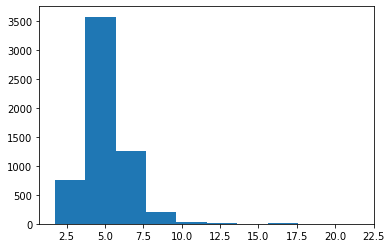

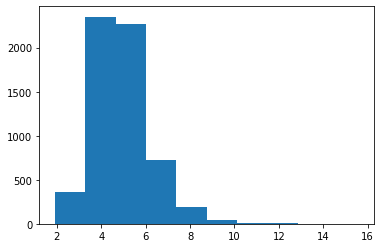

In [14]:
for i in range(10):
    plt.hist(raw_thick_scores_by_dig[i])
    plt.show()

In [15]:
# zorted_d = sorted(list(zip(x_train, y_train, thicks_disc)), key= lambda x: x[-1])

In [16]:
for i in range(10):
    print(i, i in thicks_disc)


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True


(array([ 1185.,  5541., 12592., 14866., 11799.,  6968.,  3666.,  1890.,
          815.,   678.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

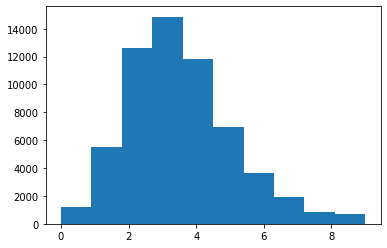

In [17]:
plt.hist(thicks_disc, bins=10)

(array([4.700e+01, 3.680e+02, 1.402e+03, 3.574e+03, 6.632e+03, 8.866e+03,
        9.741e+03, 8.599e+03, 6.862e+03, 4.848e+03, 3.278e+03, 2.096e+03,
        1.395e+03, 8.900e+02, 5.440e+02, 3.270e+02, 1.990e+02, 1.110e+02,
        7.000e+01, 4.400e+01, 2.300e+01, 2.600e+01, 2.200e+01, 7.000e+00,
        4.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.61325665,  2.11181383,  2.61037102,  3.1089282 ,  3.60748538,
         4.10604256,  4.60459975,  5.10315693,  5.60171411,  6.10027129,
         6.59882847,  7.09738566,  7.59594284,  8.09450002,  8.5930572 ,
         9.09161439,  9.59017157, 10.08872875, 10.58728593, 11.08584311,
        11.5844003 , 12.08295748, 12.58151466, 13.08007184, 13.57862903,
        14.07718621, 14.57574339, 15.07430057, 15.57285775, 16.07141494,
        16.56997212, 17.0685293 , 17.56708648, 18.06564366, 18.5

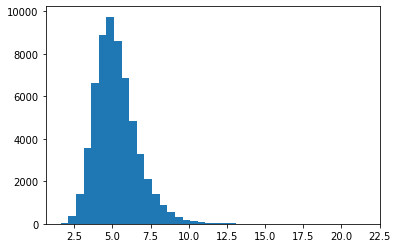

In [18]:
plt.hist(raw_thick_scores, bins=40)

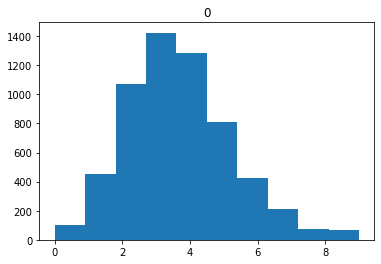

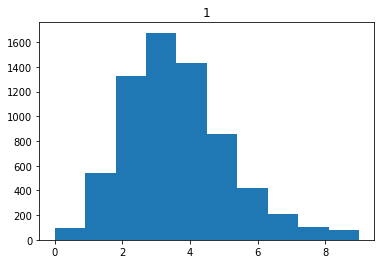

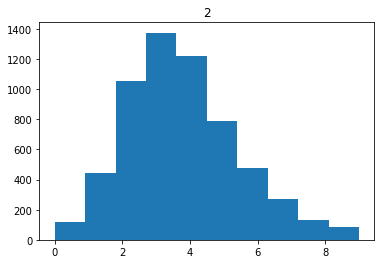

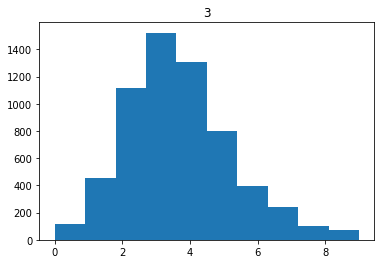

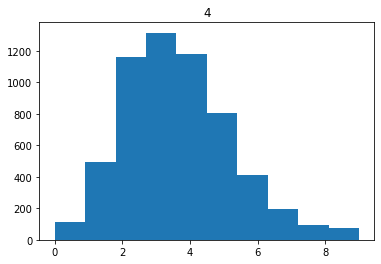

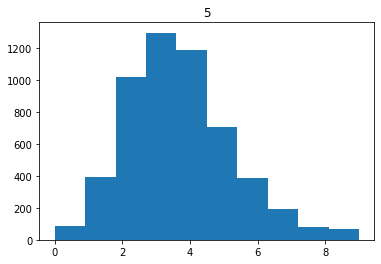

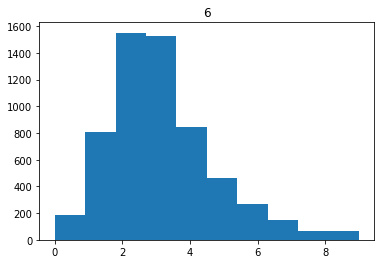

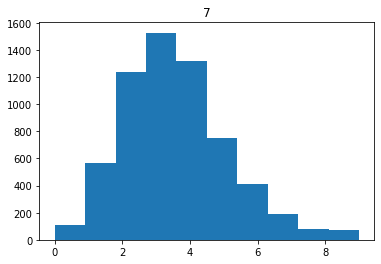

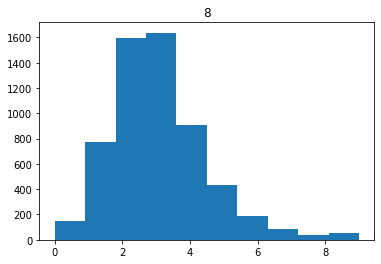

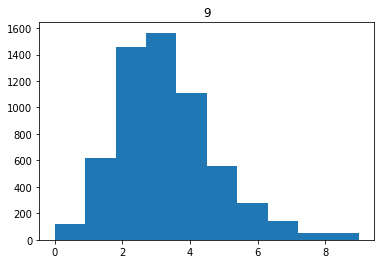

In [19]:
qs_by_dig = [[] for _ in range(10)]
for q, dig in zip(thicks_disc, y_train):
    qs_by_dig[dig].append(q)
    
for i, distr in enumerate(qs_by_dig):
    plt.hist(distr, bins=10)
    plt.title(str(i))
    plt.show()

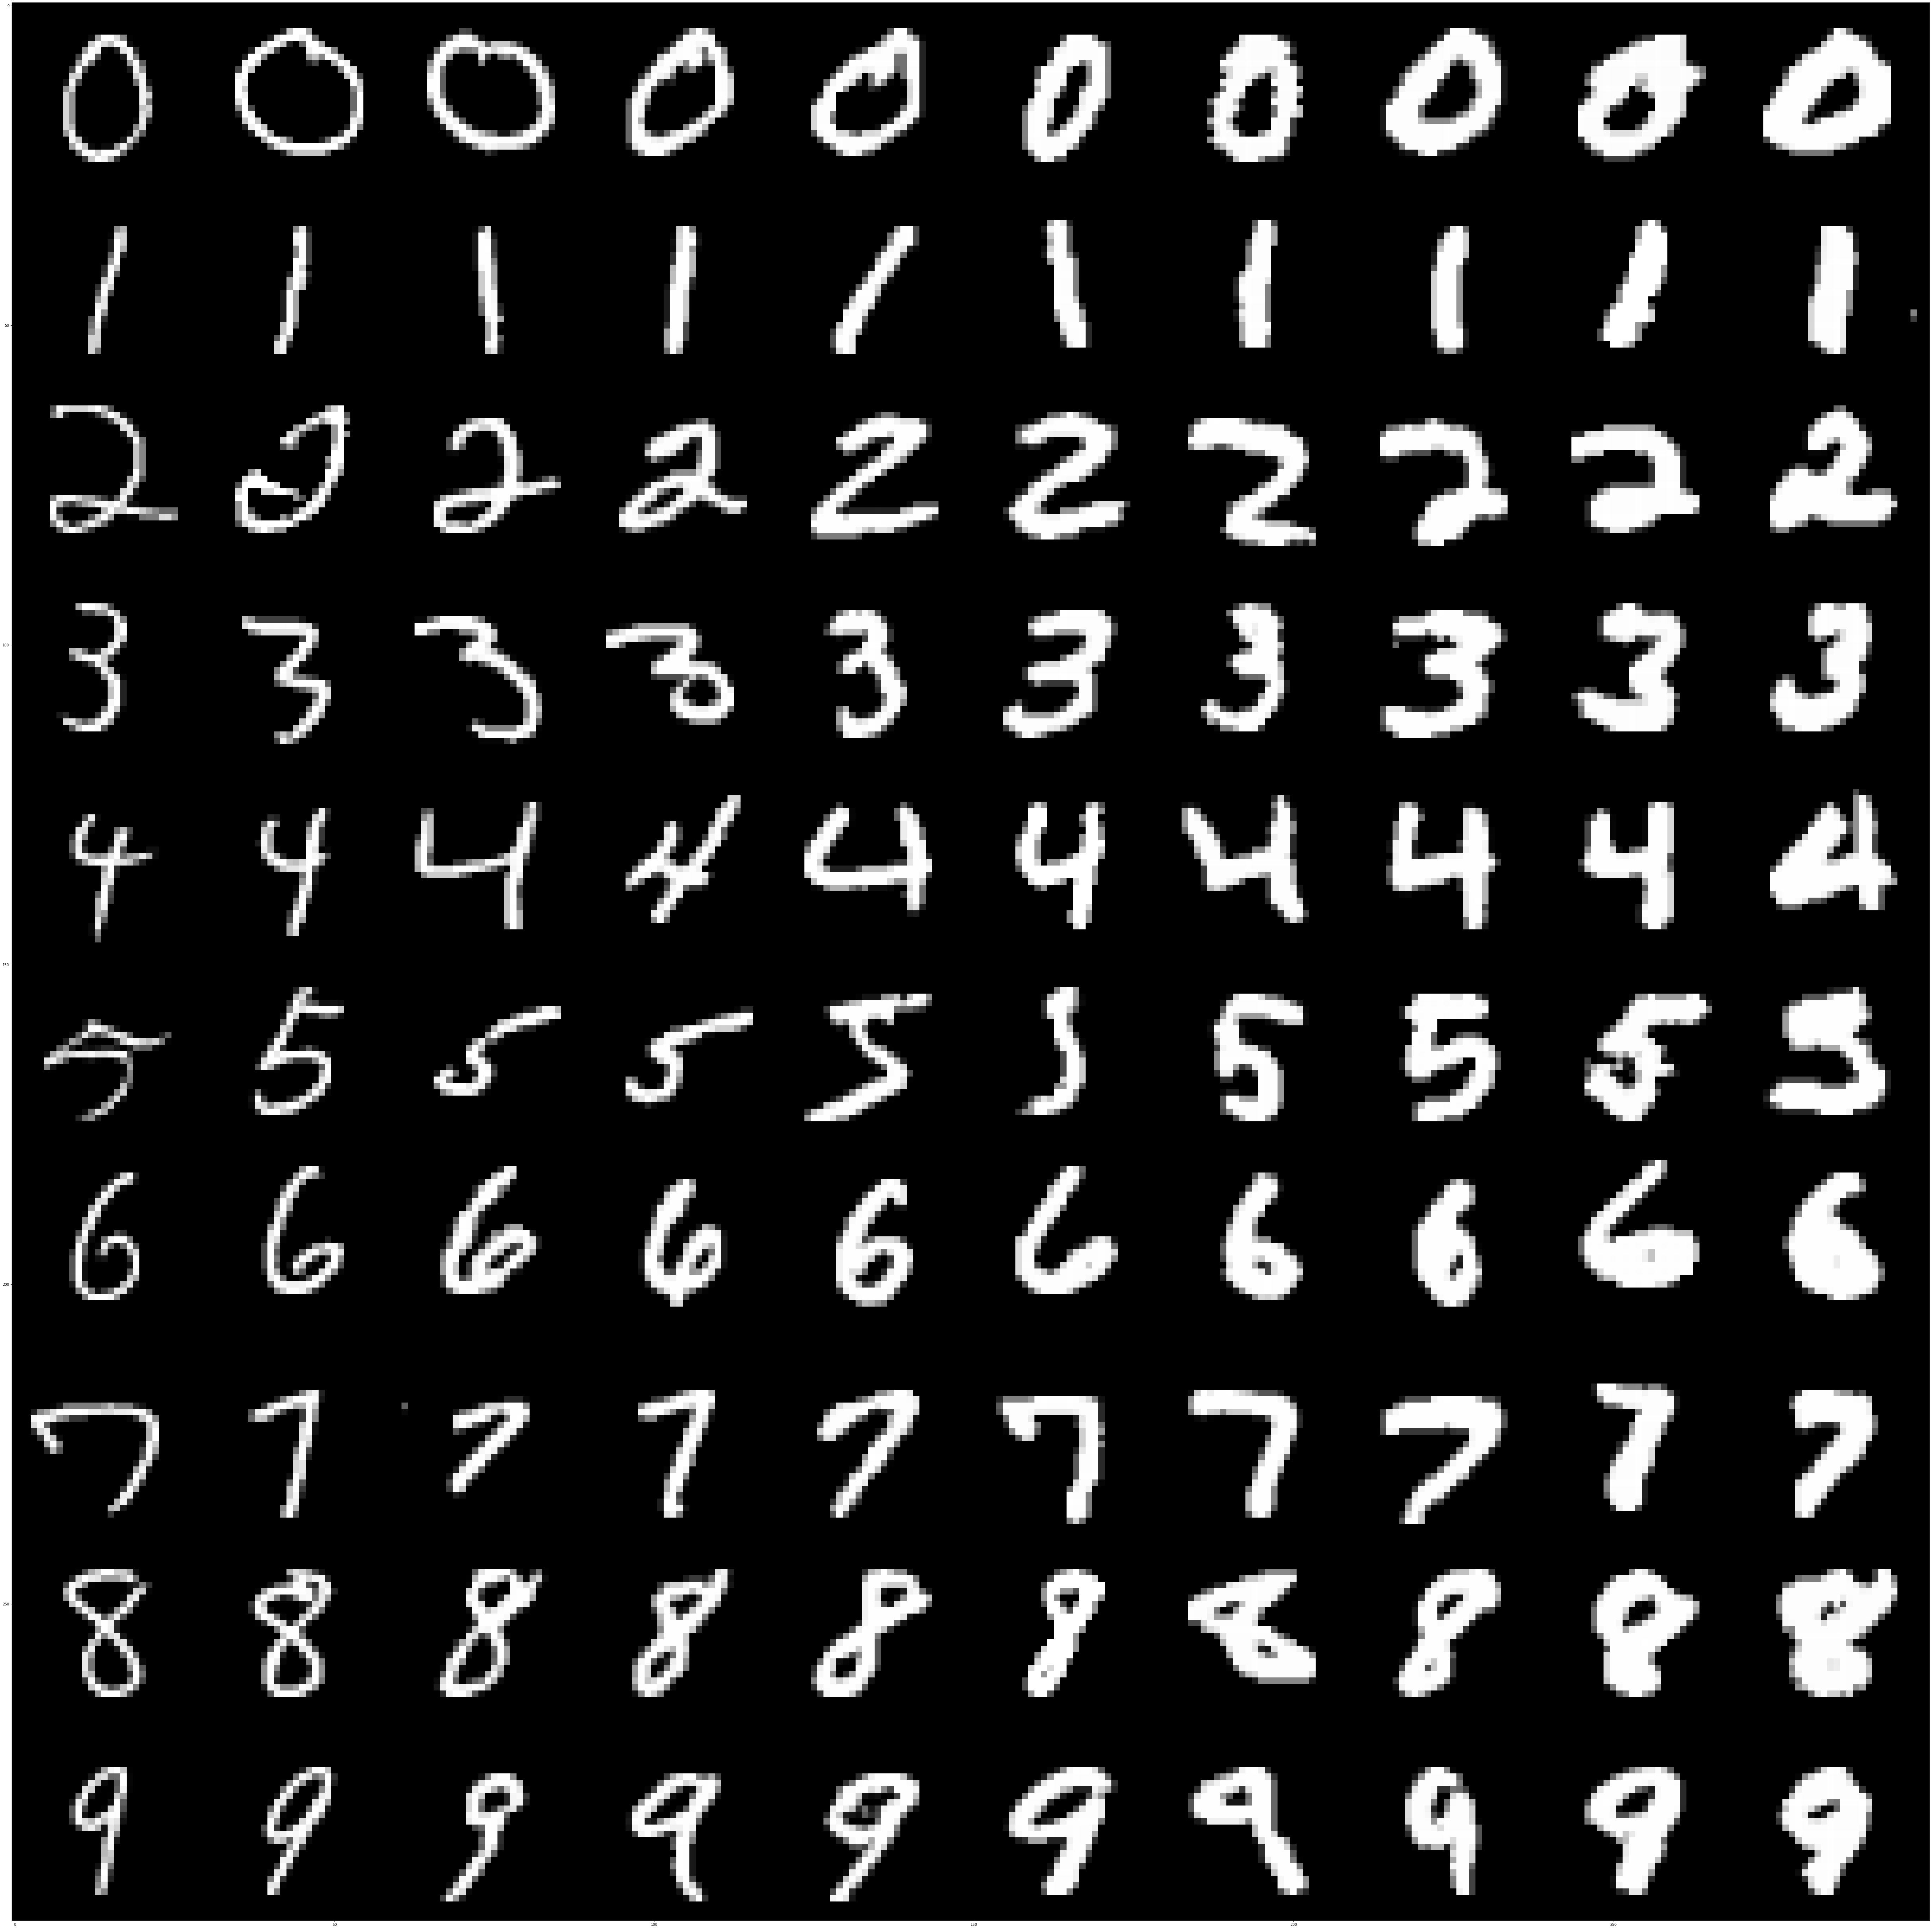

In [20]:
# n_cats = 10
start_i = 0
skip = 1

filled = np.zeros((10, n_cats), dtype=bool)
n_each = 10
step = 0.33
n_to_show = 6
spc = 2



to_show = np.zeros(((28+spc)*10, (28+spc)*n_cats ))
for i, (img, lbl, thic) in enumerate(zip(x_train, y_train, thicks_disc)):
    
    if i < start_i or i % skip != 0:
        continue

    
    row = lbl
    col = thic
    
    if not filled[row, col]:
        x_start = (28+spc)*row
        y_start = (28+spc)*col

        to_show[x_start: x_start + 28, y_start: y_start + 28] = img.reshape((28,28))
        filled[row, col] = True
    

    if np.sum(filled) == filled.size:
        break
        
plt.figure(figsize = (100, 100) )
plt.imshow(to_show, cmap='Greys_r')
plt.show()

### Alternate discrete thick score (quantile based)

In [21]:
### Code for computing quantile scores

quantiles = []
n_cats = 10

for dig in range(10):
    vals = sorted(raw_thick_scores_by_dig[dig])
    quant_i = [math.floor(len(vals)*j/n_cats)-1 for j in range(1, n_cats+ 1)]
    quantiles.append([vals[i] for i in quant_i])
    
    
def conv_raw_score_quants(sc, lbl):
    qs = quantiles[lbl]
    
    for i, val in enumerate(qs):
        if sc <= val:
            return i
        
    return len(qs) - 1

In [22]:
thicks_q = []
thicks_q_test = []

for x, lbl, raw_sc in zip(x_train, y_train, raw_thick_scores):
    
    thicks_q.append(conv_raw_score_quants(raw_sc, lbl))


for x, lbl, raw_sc in zip(x_test, y_test, raw_thick_scores_test):

    thicks_q_test.append(conv_raw_score_quants(raw_sc, lbl))


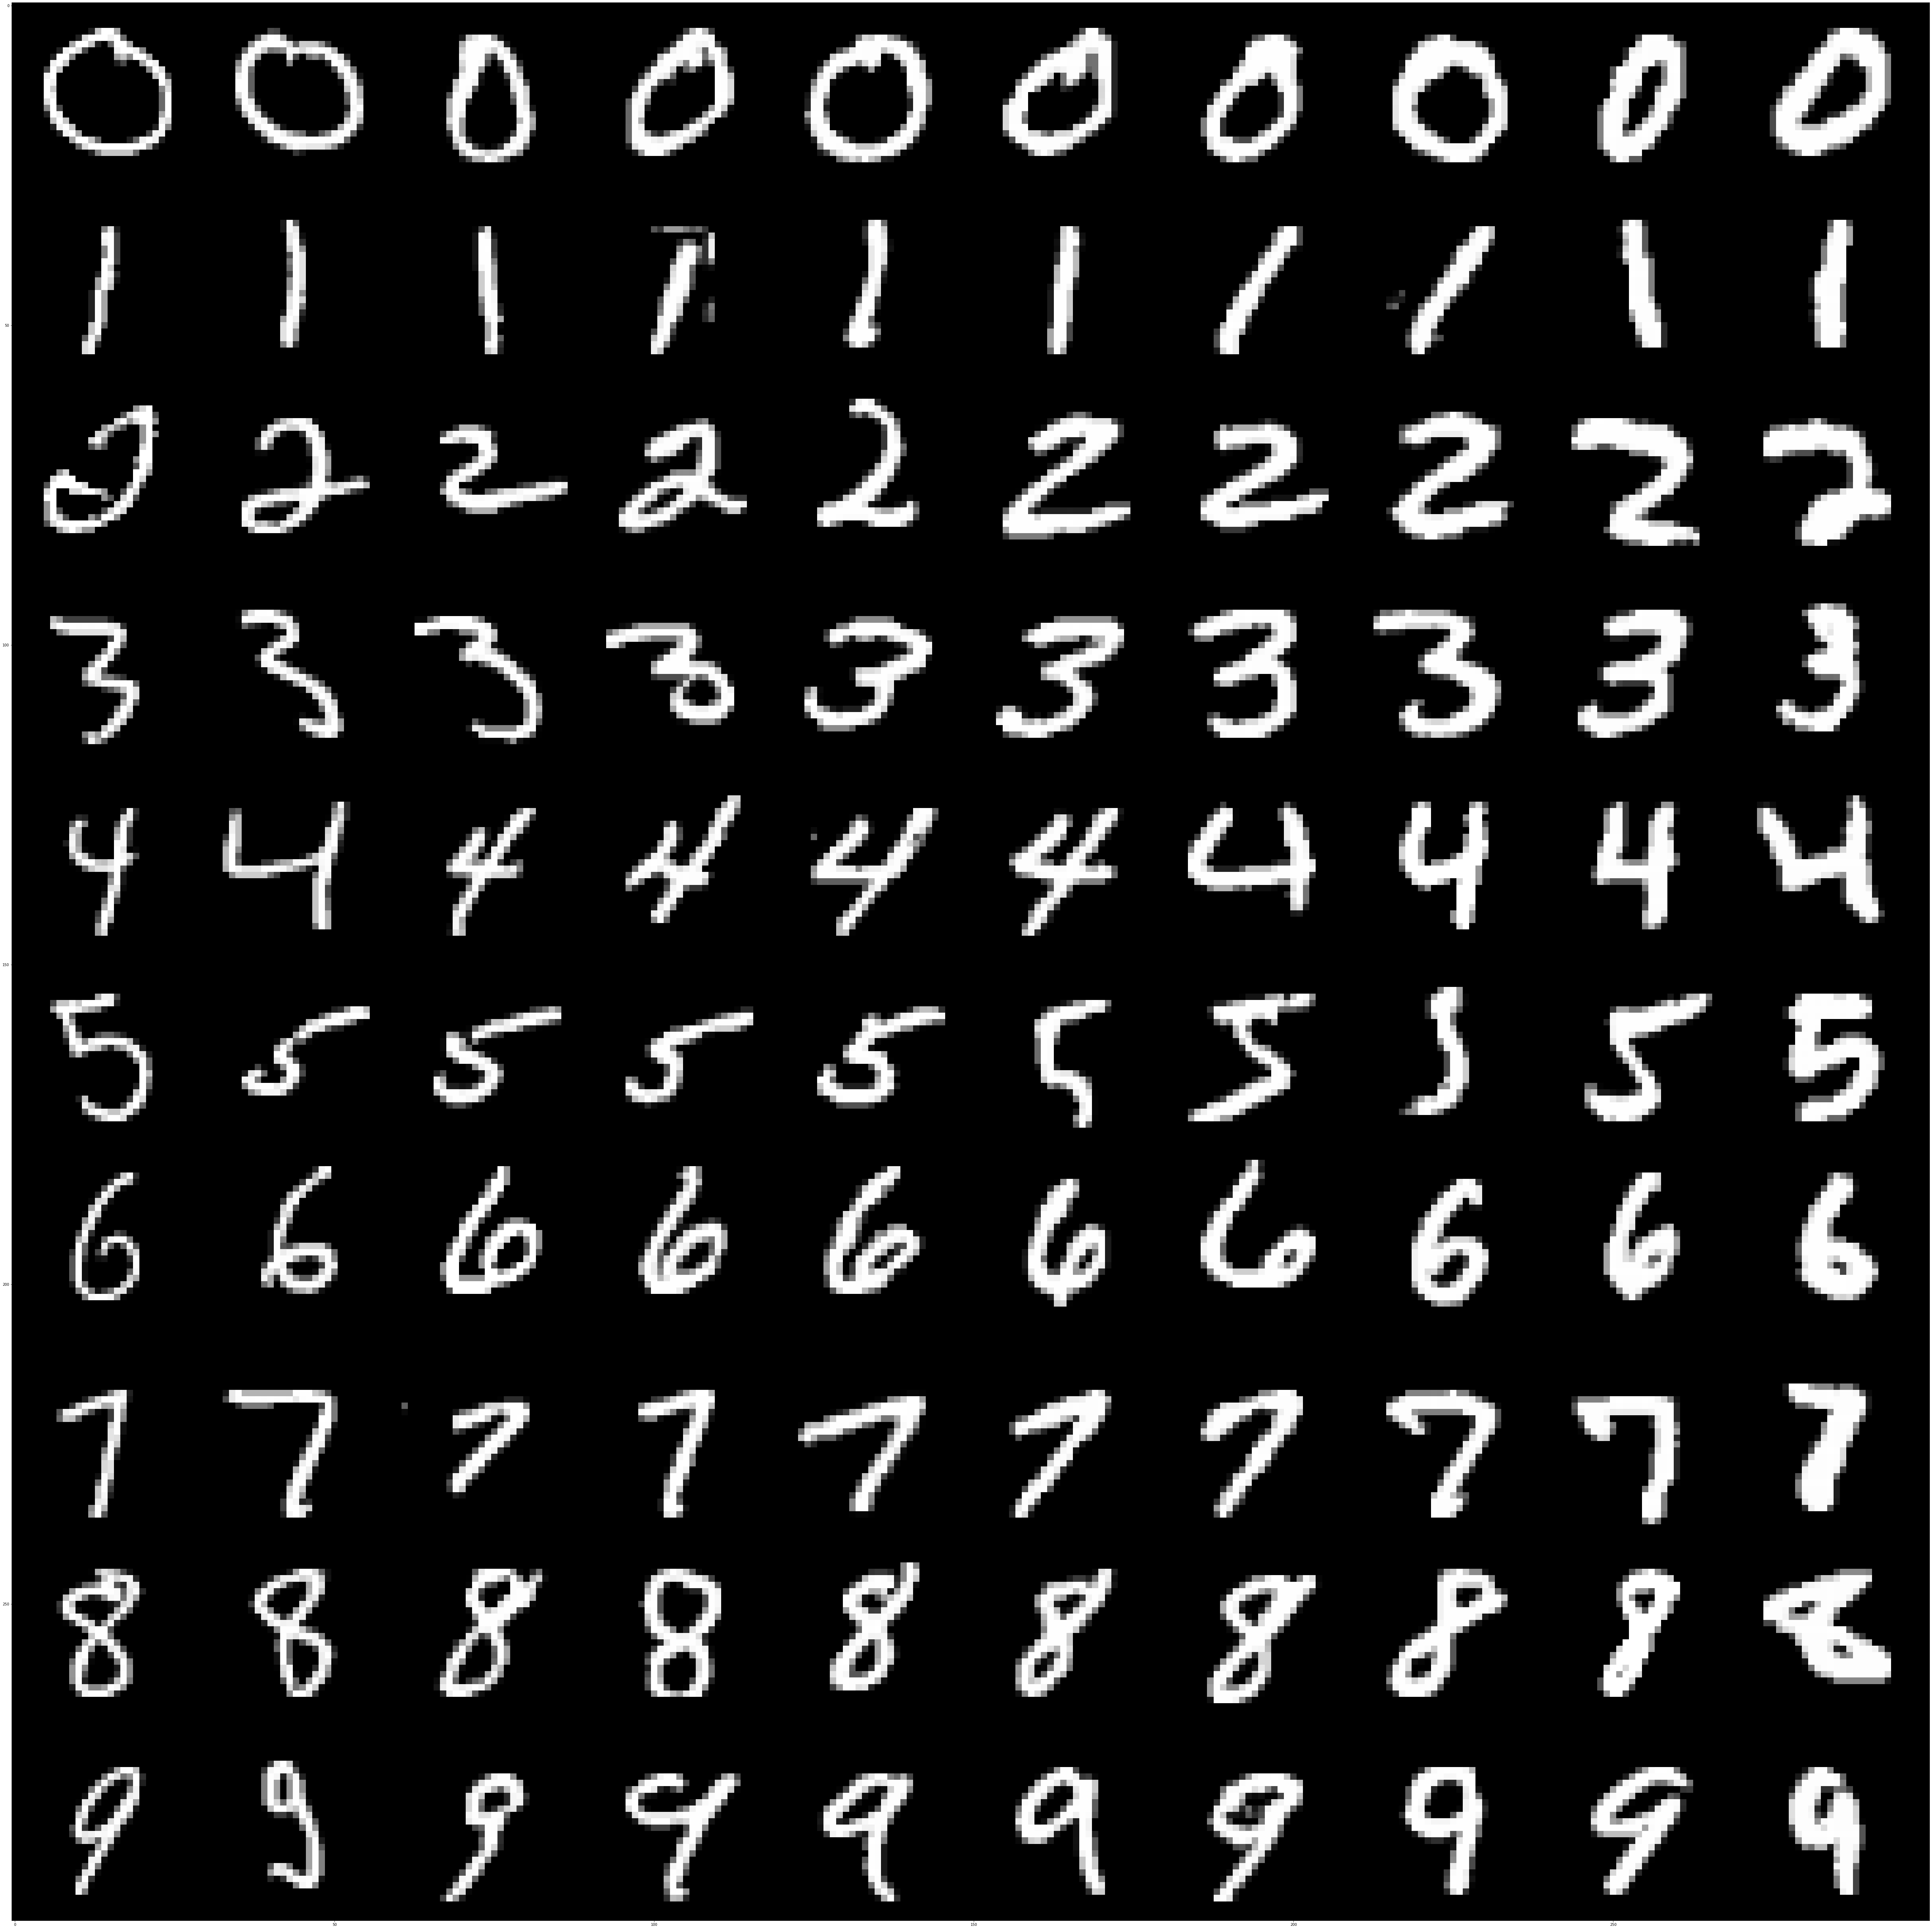

In [23]:

start_i = 0
skip = 1

filled = np.zeros((10, n_cats), dtype=bool)
n_each = 10
step = 0.33
n_to_show = 6
spc = 2


to_show = np.zeros(((28+spc)*10, (28+spc)*n_cats ))
for i, (img, lbl, thic) in enumerate(zip(x_train, y_train, thicks_q)):
    
    if i < start_i or i % skip != 0:
        continue
        
#     print(i)
    
    row = lbl
    col = thic
    
    if not filled[row, col]:
        x_start = (28+spc)*row
        y_start = (28+spc)*col

        to_show[x_start: x_start + 28, y_start: y_start + 28] = img.reshape((28,28))
        filled[row, col] = True
    
#         print("added digit", lbl, "thickness", thic)

    if np.sum(filled) == filled.size:
        break
        
plt.figure(figsize = (100, 100) )
plt.imshow(to_show, cmap='Greys_r')
plt.show()

## Thickest digits

21.555543940263945
18.59847621216523
18.469150552159107
18.4163362285619
18.303547264917434
18.29987190371042
17.207906242566356
16.239378296544462
16.23689456388433
16.183383507522624
16.121955197834378
15.906945823202138


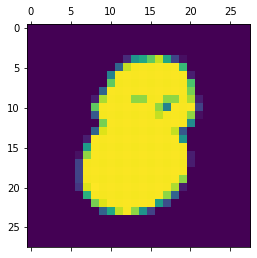

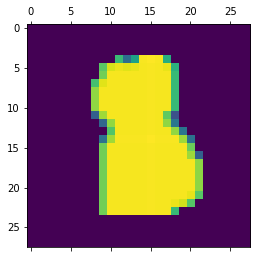

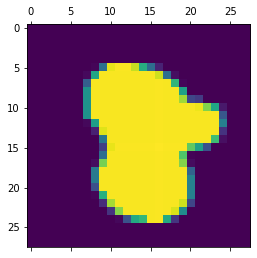

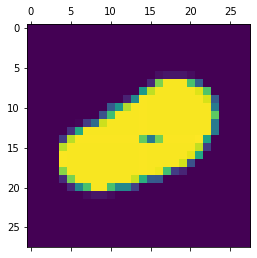

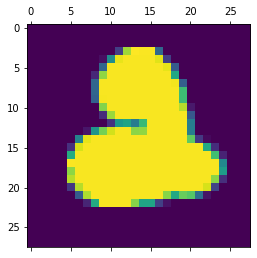

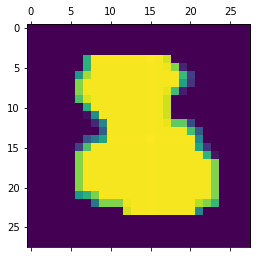

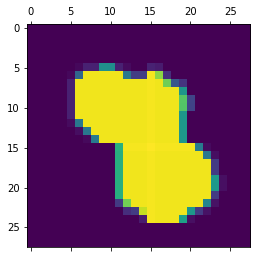

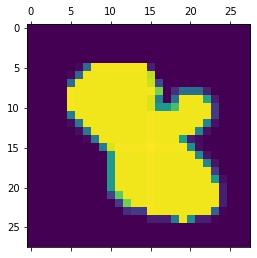

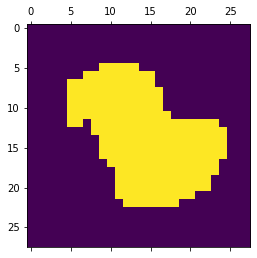

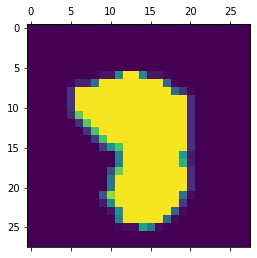

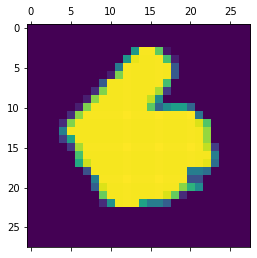

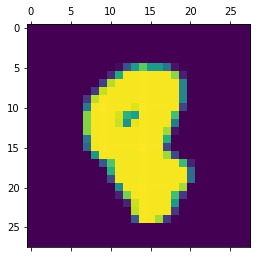

In [24]:
show_n = 10
vals = sorted(zip(raw_thick_scores, y_train, x_train), key=lambda x: x[0], reverse=True)
for i, (raw_sc, lbl, x) in enumerate(vals):
    plt.matshow(x)
    print(raw_sc)
    if i > show_n:
        break

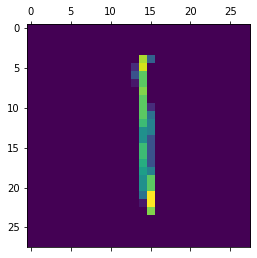

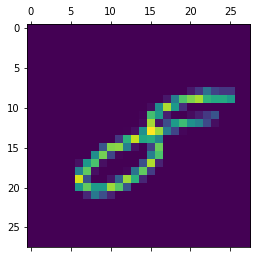

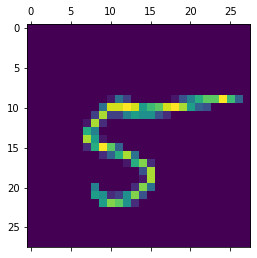

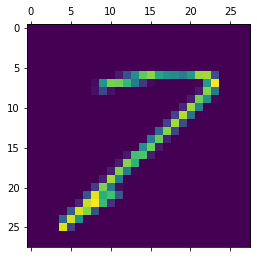

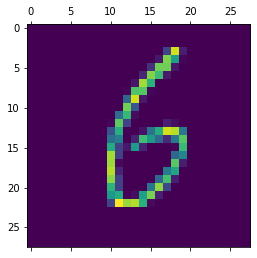

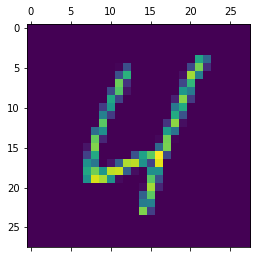

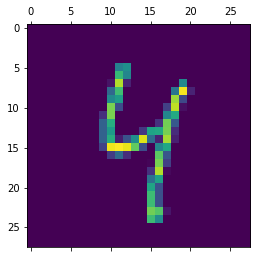

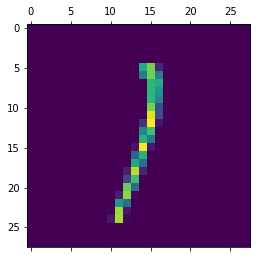

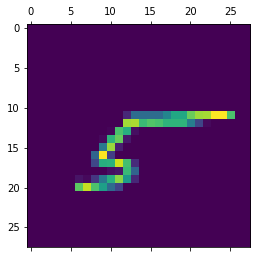

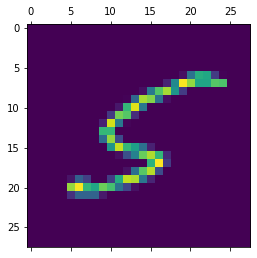

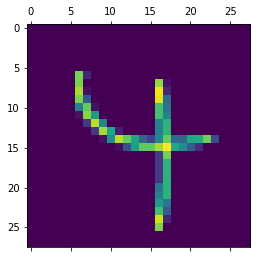

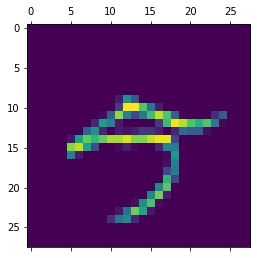

In [25]:
show_n = 10
vals = sorted(zip(raw_thick_scores, y_train, x_train), key=lambda x: x[0], reverse=False)
for i, (raw_sc, lbl, x) in enumerate(vals):
    plt.matshow(x)
    if i > show_n:
        break

In [26]:
save_data = (x_train,  y_train,  raw_thick_scores,  thicks_disc,  thicks_q,  x_test, y_test,   raw_thick_scores_test,  thicks_disc_test, thicks_q_test)
dnames =    ("x_train","y_train","raw_thick_scores","thicks_d","thicks_q","x_test","y_test","raw_thick_scores_test","thicks_d_test","thicks_q_test")

save_datasets(save_loc, save_data, dnames)